In [10]:
import os, random, cv2
import detectron2

import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from dataset import get_face_dicts
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

from mosaic import blur_bbox_regions

In [5]:
# Configs
cfg = get_cfg()
cfg_default = OmegaConf.load("default.yaml")
for k, v in cfg_default.items():
    cfg[k] = v
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-InstanceSegmentation/{cfg.backbone}.yaml"))

In [3]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.path.load_ckpt, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # should be same with training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # should be same with training
predictor = DefaultPredictor(cfg)

In [5]:
dataset_dicts = get_face_dicts(cfg.path.val, cfg.path.annot, 'val')
face_metadata = MetadataCatalog.get("face_val")

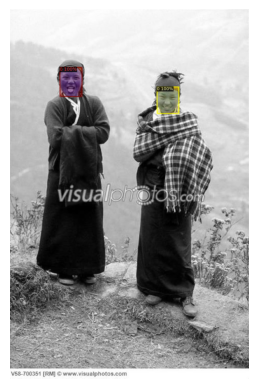

In [7]:
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_metadata,
                   scale=0.7,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    # print(outputs["instances"])
    # print(outputs["instances"].pred_boxes)
    # print(outputs["instances"].pred_boxes.tensor)
    # print(outputs["instances"].pred_classes)
    # print(outputs["instances"].scores)
    # print(outputs["instances"].pred_masks)

In [8]:
pred_boxes = outputs["instances"].pred_boxes.tensor
print(pred_boxes)
print(pred_boxes.shape) # shape: (num_boxes or num_faces, 4)
print(type(pred_boxes))

tensor([[212.3322, 248.9566, 308.4837, 374.9098],
        [628.4595, 332.4871, 722.1577, 447.8141]], device='cuda:0')
torch.Size([2, 4])
<class 'torch.Tensor'>


## Mosaic

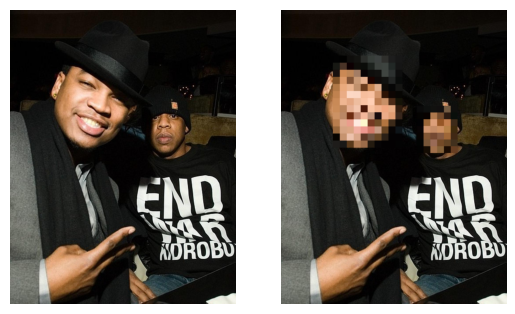

In [11]:
# example usage
import torch

image_path = os.path.join(cfg.path.val, '1--Handshaking/1_Handshaking_Handshaking_1_762.jpg')
pred_boxes = torch.Tensor([[235, 211, 550, 628], [615, 438, 800, 652]])

output_image = blur_bbox_regions(image_path=image_path, bboxes=pred_boxes, rate=30)